In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sin
%matplotlib inline

# ============================================================
# Задача на Симплекс метод

## 1) Вход:

* число переменных = n
* матрица A (n x m) (tsv, вещественные числа)
* вектор  b  ограничений типа неравнство
* вектор c функции полезности для задачи max cx 
* алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
* (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.7 баллов):
* Ответ и оптимальную точку при положительных компонентах вектора b
* Количество итераций потребовавшихся для решения задачи
* при n=2 выдавать процесс решения (draw=True)
* Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например

### Дополнительная часть  (0.4 балл):
* Максимально использовать матричные вычисления (0.2 балла)
* Работать в случае отрицательных чисел в векторе b (0.2 балла)

In [2]:
'''
    Проверка того, можно ли что-то еще увеличить в целевой функции.
'''
def isoptimal(zstar):
    for z in zstar:
        if (z < 0):
            return False
    return True

In [3]:
'''
    Определение индекса входящей переменной по правилу Бланда
    (в лексикографическом методе ее можно брать любой).
'''
def getenteringindex(size, zstar, nonbasic):
    index = size + 1
    for i in range(len(zstar)):
        if zstar[i] < 0 and nonbasic[i] < index:
            index = i + 1
    return index

In [4]:
'''
    Определение покидающей переменной по правилу Бланда.
'''
def getleavingindex(size, primalstepdirection, xstar, basic):
    values = primalstepdirection / xstar
    nans = np.isnan(values)
    values[nans] = 0
    value = np.max(values)
    if value <= 0:
        raise Exception('UNBOUNDED')
    index = size + 1
    for i in range(len(xstar)):
        if values[i] == value and basic[i] < index:
            index = i
    return (1 / values[index]), index + 1

In [5]:
'''
    Определение покидающей переменной с использованием
    лексикографического метода.
'''
def lexical(primalstepdirection, xstar, N, basic):
    values = primalstepdirection / xstar
    nans = np.isnan(values)
    values[nans] = 0
    value = np.max(values)
    rows = []
    indexes = []
    for i in range(len(xstar)):
        if values[i] == value:
            row = [xstar[i] / basic[i]]
            row += list(N[i] / (-basic[i]))
            rows += [row]
            indexes += [i]
    index = np.argmin(rows, axis=0)[0]
    return (1 / value), indexes[index] + 1

In [6]:
'''
    Смена базиса.
'''
def changebasis(basic, nonbasic,
                enteringindex, leavingindex):
    temp = basic[leavingindex - 1]
    basic[leavingindex - 1] = nonbasic[enteringindex - 1]
    nonbasic[enteringindex - 1] = temp

In [7]:
'''
    Изменение матриц.
'''
def changematrix(B, N,
                 enteringindex, leavingindex):
    temp = B[:, leavingindex - 1].copy()
    B[:, leavingindex - 1] = N[:, enteringindex - 1]
    N[:, enteringindex - 1] = temp

In [8]:
'''
    Определение решения.
'''
def solution(n, m, c, basic, nonbasic, xstar):
    answer = np.zeros(n + m)
    answer[basic - 1] = xstar
    answer[nonbasic - 1] = 0
    return answer[:n], c @ (answer[:n]).T

In [9]:
'''
    Получение точки, которая была обработана
    на одной из итераций.
'''
def getpoint(n, m, xstar, basic, nonbasic):
    values = np.zeros(n + m)
    values[basic - 1] = xstar
    values[nonbasic - 1] = 0
    return list(values[:n])

In [10]:
'''
    Проверка угловой точки на то, является
    ли она базисной.
'''
def ok(A, b, x, y):
    vector = np.array([x, y])
    values = A @ vector.T
    for i in range(len(values)):
        if values[i] > b[i]:
            return False
    return True

In [11]:
'''
    Функция, которая возвращает две точки прямой,
    соответсвующей одной из строк матрицы.
'''
def getpoints(a, b):
    y = 0
    x = 0
    other = []
    if a[1] != 0:
        y = b / a[1]
    if a[0] != 0:
        x = b / a[0]
    if x > 0 and y > 0:
        other = [[0, y], [x, 0]]
    elif x > 0 and y < 0:
        other = [[x, 0], [10 * x, (b - a[0] * 10 * x) / a[1]]]
    elif y > 0 and x < 0:
        other = [[0, y], [(b - a[1] * 10 * y) / a[0], 10 * y]]
    elif y == 0 and x > 0:
        other = [[x, 0], [x, 10]]
    elif x == 0 and y > 0:
        other = [[0, y], [10, y]]
    return other

In [12]:
'''
    Функция, которая формирует величины, помогающие
    проверять пересечение двух прямых.
'''
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C

In [13]:
'''
    Возвращает точку пересечения прямых.
'''
def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x, y
    else:
        return 0, 0

In [14]:
'''
    Первый шаг в дуальном методе.
'''
def pivot(xstar, zstar, N, basic, nonbasic):
    m = len(basic)
    leavingindex = np.argmin(xstar)
    row = N[leavingindex]
    N = N - row
    N[leavingindex] = -row
    N[:, 0] = -np.ones(m)
    changebasis(basic, nonbasic, 1, leavingindex + 1)
    value = -xstar[leavingindex]
    xstar = xstar + value
    xstar[leavingindex] = value
    zstar = row
    zstar[0] = 1
    return xstar, zstar, N, basic, nonbasic

In [15]:
'''
    1 фаза симплекс-алгоритма.
'''
def auxiliary(A, b):
    n = A.shape[1]
    m = A.shape[0]
    basic = np.arange(n + 1, n + m + 1)
    nonbasic = np.arange(0, n + 1)
    xstar = b.copy()
    zstar = [-1] + [0] * n
    B = np.eye(m)
    N = np.c_[-np.ones(m), A.copy()]
    xstar, zstar, N, basic, nonbasic = pivot(xstar, zstar, N,  basic, nonbasic)
    iteration = 0
    while True:
        if (isoptimal(zstar)):
            flag = True
            for i in range(n + 1):
                if nonbasic[i] == 0:
                    N = np.delete(N, i, 1)
                    nonbasic = np.delete(nonbasic, i, 0)
                    flag = False
                    break
            if flag:
                raise Exception('INFEASIBLE')
            return basic, nonbasic, N, xstar
        else:
            iteration += 1
            enteringindex = np.argmin(zstar)
            vector = np.eye(n + 1)[enteringindex]
            primalstepdirection = np.linalg.inv(B) @ N @ vector.T
            values = primalstepdirection / xstar
            leavingindex = np.argmax(values)
            t = 1 / values[leavingindex]
            vector = np.eye(m)[leavingindex]
            dualstepdirection = -(np.linalg.inv(B) @ N).T @ vector.T
            s = zstar[enteringindex] / dualstepdirection[enteringindex]
            xstar = xstar - t * primalstepdirection
            zstar = zstar - s * dualstepdirection
            zstar[enteringindex] = s
            xstar[leavingindex] = t
            changebasis(basic, nonbasic,
                        enteringindex + 1, leavingindex + 1)
            changematrix(B, N, enteringindex + 1,
                         leavingindex + 1)
            value = B[leavingindex][leavingindex]
            B[leavingindex] = B[leavingindex] / value
            N[leavingindex] = N[leavingindex] / value
            for i in range(m):
                if i == leavingindex:
                    continue
                temp = B[i][leavingindex]
                B[i][leavingindex] = 0
                N[i] = N[i] - temp * N[leavingindex]

In [16]:
'''
    Симплекс-алгоритм.
'''
def simplex(n, A, b, c, method='bland', start_point=None, draw=False):
    supplement = 0
    if start_point != None:
        b = b - A @ start_point.T
        supplement = c @ start_point.T
    m = A.shape[0]
    basic = np.arange(n + 1, n + m + 1)
    nonbasic = np.arange(1, n + 1)
    xstar = b.copy()
    zstar = -(c.copy())
    B = np.eye(m)
    N = A.copy()
    iteration = 0
    points = [[0, 0]]
    aux = False
    if not isoptimal(xstar):
        aux = True
        oldnonbasic = nonbasic.copy()
        temp = zstar.copy()
        newzstar = np.zeros(n)
        basic, nonbasic, N, xstar = auxiliary(N, xstar)
        for i in range(n):
            if oldnonbasic[i] in basic:
                index = -1
                for j in range(m):
                    if oldnonbasic[i] == basic[j]:
                        index = j
                newzstar -= temp[i] * N[index]
            else:
                index = -1
                for j in range(n):
                    if nonbasic[j] == oldnonbasic[i]:
                        index = j
                newzstar[index] += temp[i]
        zstar = newzstar.copy()
    while True:
        if (isoptimal(zstar)):
            point, value = solution(n, m, c, basic, nonbasic, xstar)
            if start_point != None:
                value += supplement
                point += start_point
            if draw and n == 2 and not aux:
                points = np.array(points)
                if start_point != None:
                    points += start_point
                    b = b + A @ start_point.T
                for i in range(iteration + 1):
                    xmin = -0.1
                    xmax = -1
                    ymin = -0.1
                    ymax = -1
                    plt.plot([0, 10], [0, 0], c='blue', alpha=0.2)
                    plt.plot([0, 0], [0, 10], c='blue', alpha=0.2)
                    if ok(A, b, 0, 0):
                        plt.scatter(0, 0, c='black')
                    for j in range(m):
                        y = 0
                        x = 0
                        dots = []
                        if A[j][1] != 0:
                            y = b[j] / A[j][1]
                        if A[j][0] != 0:
                            x = b[j] / A[j][0]
                        if x > 0 and y > 0:
                            plt.plot([0, x], [y, 0], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[0, y], [x, 0]]
                        elif x > 0 and y < 0:
                            plt.plot([x, 10 * x], [0, (b[j] - A[j][0] * 10 * x) / A[j][1]], c='blue', alpha=0.2)
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[x, 0], [10 * x, (b[j] - A[j][0] * 10 * x) / A[j][1]]]
                        elif y > 0 and x < 0:
                            plt.plot([0, (b[j] - A[j][1] * 10 * y) / A[j][0]], [y, 10 * y], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            dots = [[0, y], [(b[j] - A[j][1] * 10 * y) / A[j][0], 10 * y]]
                        elif y == 0 and x > 0:
                            plt.plot([x, x], [0, 10], c='blue', alpha=0.2)
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[x, 0], [x, 10]]
                        elif x == 0 and y > 0:
                            plt.plot([0, 10], [y, y], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            dots = [[0, y], [10, y]]
                        for k in range(m):    
                            if k == j:
                                continue
                            else:
                                L1 = line(dots[0], dots[1])
                                dots = getpoints(A[k], b[k])
                                L2 = line(dots[0], dots[1])
                                x, y = intersection(L1, L2)
                                if ok(A, b, x, y):
                                    plt.scatter(x, y, c='black')
                                    if y > ymax:
                                        ymax = y
                                    if x > xmax:
                                        xmax = x
                    plt.scatter(points[i][0], points[i][1], c='red')
                    plt.xlim((xmin, xmax + 1))
                    plt.ylim((ymin, ymax + 1))
                    plt.title('iteration = %d; point = (%.2f, %.2f)' % (i, points[i][0], points[i][1]))
                    plt.show()
            return value, point, iteration
            break
        else:
            iteration += 1
            enteringindex = getenteringindex(n + m, zstar, nonbasic)
            vector = np.eye(n)[enteringindex - 1]
            primalstepdirection = np.linalg.inv(B) @ N @ vector.T
            t = 0
            leavingindex = 0
            if method == 'bland':
                t, leavingindex = getleavingindex(n + m, primalstepdirection, xstar, basic)
            elif method == 'lexical':
                t, leavingindex = lexical(primalstepdirection, xstar, N, basic)
            vector = np.eye(m)[leavingindex - 1]
            dualstepdirection = -(np.linalg.inv(B) @ N).T @ vector.T
            s = zstar[enteringindex - 1] / dualstepdirection[enteringindex - 1]
            xstar = xstar - t * primalstepdirection
            zstar = zstar - s * dualstepdirection
            zstar[enteringindex - 1] = s
            xstar[leavingindex - 1] = t
            changebasis(basic, nonbasic,
                        enteringindex, leavingindex)
            changematrix(B, N,
                         enteringindex, leavingindex)
            if draw and n == 2 and not aux:
                points += [getpoint(n, m, xstar, basic, nonbasic)]

In [17]:
'''
    Проверка заданной точки на оптимальность.
'''
def checkoptimal(A, b, c, x):
    value, point, iteration = simplex(A.shape[1], A, b, c)
    flag = True
    values = A @ x.T
    for i in range(len(values)):
        if values[i] > b[i]:
            flag = False
    if flag:
        return np.array_equal(value, c @ x.T)

## Тесты

In [18]:
A = np.array([[1, 2], [3, 2], [-1, -3]])
b = np.array([8, 12, -12])
c = np.array([1, 1])
simplex(2, A, b, c)

Exception: INFEASIBLE

In [19]:
A = np.array([[1, -1], [2, -1]])
b = np.array([10, 40])
c = np.array([2, 1])
simplex(2, A, b, c)

Exception: UNBOUNDED

In [20]:
A = np.array([[-1, 1], [-1, -2], [0, 1]])
b = np.array([-1, -2, 1])
c = np.array([-2, -1])
simplex(2, A, b, c)

(-3.0000000000000004, array([ 1.33333333,  0.33333333]), 0)

In [21]:
A = np.array([[2, -1, 2], [2, -3, 1], [-1, 1, -2]])
b = np.array([4, -5, -1])
c = np.array([1, -1, 1])
simplex(3, A, b, c)

(0.60000000000000053, array([ 0. ,  2.8,  3.4]), 2)

In [22]:
A = np.array([[0.2, -0.2, -0.6], [-0.6, -0.4, -0.2], [1, 0, 1]])
b = np.array([1.6, 2.2, 3])
c = np.array([0.2, -0.2, 0.4])
simplex(3, A, b, c)

(1.2000000000000002, array([ 0.,  0.,  3.]), 2)

In [23]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
x = np.array([4, 5])
checkoptimal(A, b, c, x)

True

In [24]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
start_point = np.array([1, 1])
simplex(2, A, b, c, method='lexical', start_point=start_point)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(31.0, array([ 4.,  5.]), 3)

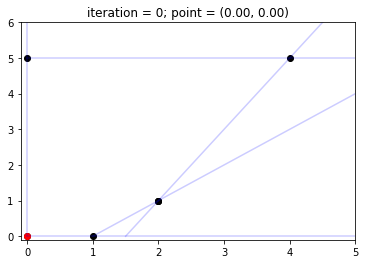

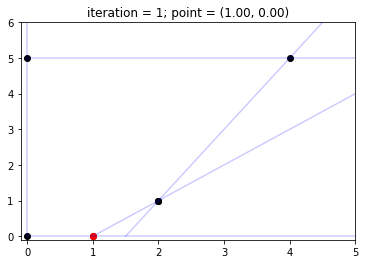

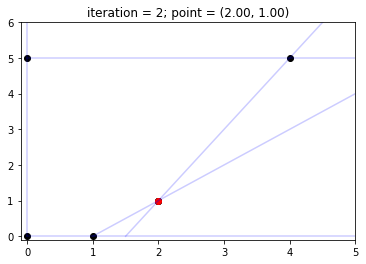

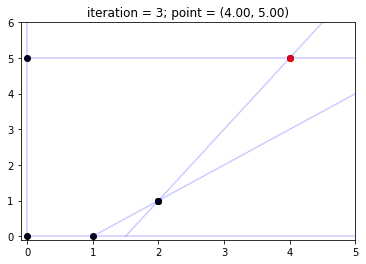

(31.0, array([ 4.,  5.]), 3)

In [25]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
simplex(2, A, b, c, draw=True)

In [26]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
start_point = np.array([1, 1])
simplex(2, A, b, c, start_point=start_point)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(31.0, array([ 4.,  5.]), 3)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


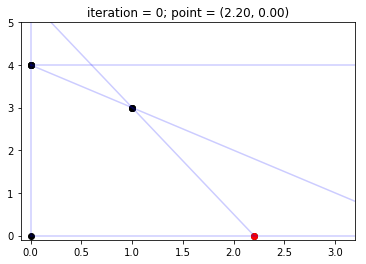

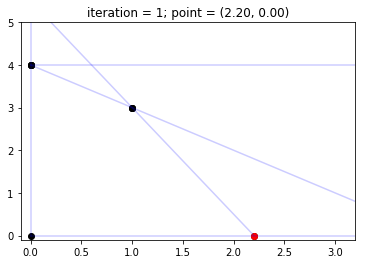

(22.0, array([ 2.2,  0. ]), 1)

In [27]:
A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
start_point = np.array([2.2, 0])
simplex(2, A, b, c, method='lexical', start_point=start_point, draw=True)

In [28]:
A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
simplex(2, A, b, c)

A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
start_point = np.array([2.2, 0])
simplex(2, A, b, c, start_point=start_point)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(22.0, array([ 2.2,  0. ]), 1)

In [29]:
A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
start_point = np.array([1, 0, 1, 0])
simplex(4, A, b, c, method='lexical', start_point=None)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


(1.0, array([ 1.,  0.,  1.,  0.]), 5)

In [30]:
A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
simplex(4, A, b, c)

A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
start_point = np.array([1, 0, 1, 0])
simplex(4, A, b, c, start_point=start_point)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(1.0, array([ 1.,  0.,  1.,  0.]), 2)

In [31]:
A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
simplex(4, A, b, c)

A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
start_point = np.array([0, 1, 0, 0])
simplex(4, A, b, c, start_point=start_point)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(7.0, array([ 0.,  1.,  0.,  0.]), 1)

In [32]:
A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
start_point = np.array([0, 1, 0, 0])
simplex(4, A, b, c, method='lexical', start_point=None)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


(7.0, array([ 0.,  1.,  0.,  0.]), 1)

# ==========================================================
# Задача на МНК

In [52]:
''' Пусть физический закон описывается зависимостью 
    некоторого измеряемого значения y(x, a) 
    от времени и координаты x при параметрах a:
'''

def function(t, a): 
    return a[2] * sin(t) + a[1] * t + a[0]

In [53]:
''' Дан набор координат t размера m, значения распределены равномерно. 
    Пусть m = 200.
'''

m = 200
time = np.array([i * 10.0 / m for i in range(m)])

In [54]:
''' Для каждого момента времени t сгенерируйте соответствующее
    значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера:
'''

a = np.array([10, 100, 1000])

In [55]:
''' Выберем параметр b.
'''

b = 500

In [56]:
''' Результаты измерений отличаются от истинных значений 
    в силу действия случайной аддитивной помехи
    (случайность подчиняется нормальному закону распределения N(0, b))
'''

def get_y(a, b):
    y_real = np.array([function(i, a) for i in time])
    y_corr = y_real + np.random.normal(0, b, m)
    return y_real, y_corr

In [57]:
''' Сгенерируем значения: исходные и с помехами.
'''

y_real, y_corr = get_y(a, b)

In [58]:
''' По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    1) method = 0 -> сумма квадратов невязок будет минимальна;
    2) method = 1 -> сумма абсолютных значений невязок будет минимальна;
    3) method = 2 -> максимальное абсолютное значение невязки будет минимально.
'''

def get_params(data, time, method=0):
    if method == 0:
        A = np.array([[1, t, sin(t)] for t in time])
        return np.linalg.inv(A.T @ A) @ A.T @ data
    elif method == 1:
        A = np.array([[1, t, sin(t)] for t in time])
        E = np.eye(m)
        B = np.vstack((np.hstack((-E, A)), np.hstack((-E, -A))))
        b = np.hstack((data, -data))
        c = -np.hstack((np.ones(m), np.zeros(3)))
        start_point = np.hstack((y_corr, np.zeros(3)))
        return simplex(len(c), B, b, c, start_point=start_point)
    elif method == 2:
        A = np.array([[1, t, sin(t)] for t in time])
        E = np.array([np.ones(m)])
        B = np.vstack((np.hstack((-E.T, A)), np.hstack((-E.T, -A))))
        b = np.hstack((data, -data))
        c = -np.hstack((np.ones(1), np.zeros(3)))
        return simplex(len(c), B, b, c)

1 и 2 методы сводятся к задаче линейного программирования:
* В первом случае 
    * $max\ cx$
    $$  \left(\begin{array}{cc}  
           -E & A\\  
           -E & -A 
        \end{array}\right)
        x \leq
        \left(\begin{array}{c}  
           y \\  
           -y  
        \end{array}\right)
    $$
    
    * $x = (x_1, \ldots, x_m, a_0, a_1, a_2)$
    * $c = (-1, \ldots, -1, 0, 0, 0)$
    * Так как это эквивалентно
    
      $\sum |a_2 \sin t_i + a_1 t_i + a_0 - y_i^{наб} | \to \min$ или же

      $\forall i: a_2 \sin t_i + a_1 t_i + a_0 - y_i^{наб} \in [-x_i, +x_i]; ~~\sum x_i \to \min $

* Во втором случае
    * $max\ cx$
    $$  \left(\begin{array}{cc}  
            \left(\begin{array}{c}  
               -1\\
               \vdots \\
               -1 
            \end{array}\right) & A\\  
            \left(\begin{array}{c}  
               -1\\
               \vdots \\
               -1 
            \end{array}\right) & -A\\ 
        \end{array}\right)
        x \leq
        \left(\begin{array}{c}  
           y \\  
           -y  
        \end{array}\right)
    $$
    * $x = (x_0, a_0, a_1, a_2)$
    * $c = (-1, 0, 0, 0)$
    * Так как это эквивалентно
      
      $\max |a_2 \sin t_i + a_1 t_i + a_0 - y_i^{наб} | \to \min$ или же

      $\forall i: a_2 \sin t_i + a_1 t_i + a_0 - y_i^{наб} \in [-x_0, +x_0]; ~~x_0 \to \min $

## Задание 1

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


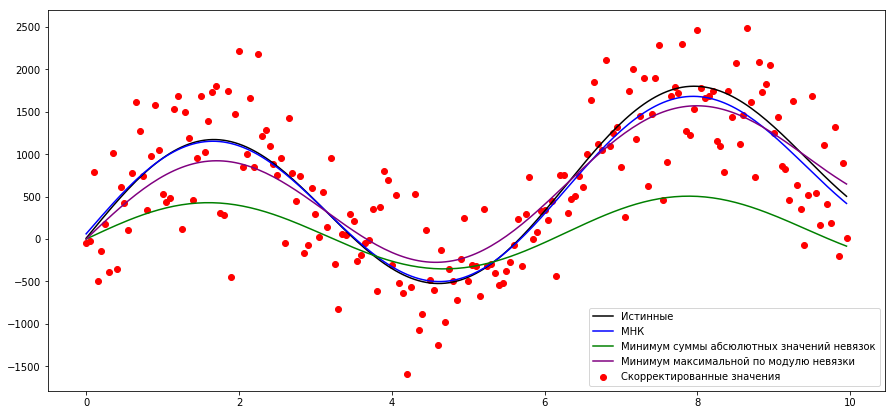

In [59]:
plt.figure(figsize=(15,7))

plt.scatter(time, y_corr, c='red', label='Скорректированные значения')

y = np.array([function(t, a) for t in time])
plt.plot(time, y, c='black', label='Истинные')

astar = np.zeros((3,3))

astar[0] = get_params(y_corr, time)
y = np.array([function(t, astar[0]) for t in time])
plt.plot(time, y, c='blue', label='МНК')

astar[1] = get_params(y_corr, time, method=1)[1][-3:]
y = np.array([function(t, astar[1]) for t in time])
plt.plot(time, y, c='green', label='Минимум суммы абсюлютных значений невязок')

astar[2] = get_params(y_corr, time, method=2)[1][-3:]
y = np.array([function(t, astar[2]) for t in time])
plt.plot(time, y, c='purple', label='Минимум максимальной по модулю невязки')

plt.legend()
plt.show()

In [60]:
print('Отличие истинных параметров и параметров, полученных с помощью приближений:')
print('\tИстинные:', a)
print('\tМНК:', np.round(astar[0], 2))
print('\tМинимум суммы абсолютных значений невязок:', np.round(astar[1], 2))
print('\tМинимум максимальной по модулю невязки:', np.round(astar[2], 2))

Отличие истинных параметров и параметров, полученных с помощью приближений:
	Истинные: [  10  100 1000]
	МНК: [  61.32   84.15  955.23]
	Минимум суммы абсолютных значений невязок: [   0.     12.22  409.12]
	Минимум максимальной по модулю невязки: [   0.    103.11  753.08]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encount

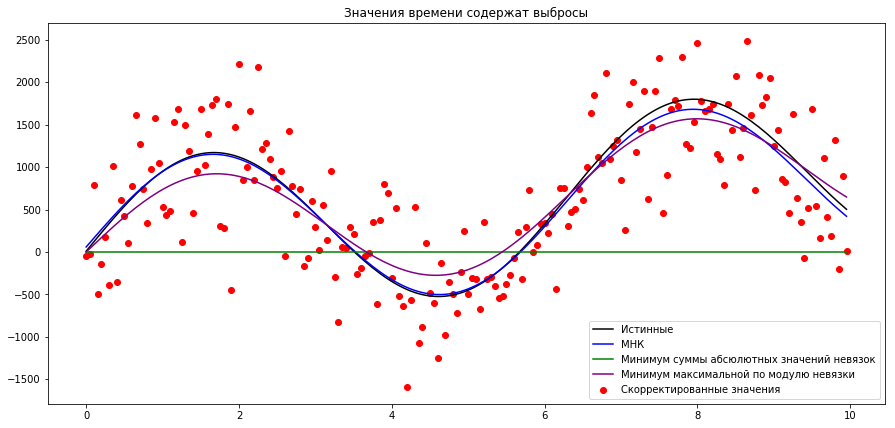

In [61]:
plt.figure(figsize=(15,7))

plt.scatter(time, y_corr, c='red', label='Скорректированные значения')

y = np.array([function(t, a) for t in time])
plt.plot(time, y, c='black', label='Истинные')

y_corrupt = y_corr.copy()
y_corrupt[0] -= 50
y_corrupt[-1] += 50

astar = np.zeros((3,3))

astar[0] = get_params(y_corrupt, time)
y = np.array([function(t, astar[0]) for t in time])
plt.plot(time, y, c='blue', label='МНК')

astar[1] = get_params(y_corrupt, time, method=1)[1][-3:]
astar[1] = np.nan_to_num(astar[1])
y = np.array([function(t, astar[1]) for t in time])
plt.plot(time, y, c='green', label='Минимум суммы абсюлютных значений невязок')

astar[2] = get_params(y_corrupt, time, method=2)[1][-3:]
y = np.array([function(t, astar[2]) for t in time])
plt.plot(time, y, c='purple', label='Минимум максимальной по модулю невязки')


plt.title('Значения времени содержат выбросы')
plt.legend()
plt.show()

In [62]:
print('Отличие истинных параметров и параметров, полученных с помощью приближений:')
print('\tИстинные:', a)
print('\tМНК:', np.round(astar[0], 2))
print('\tМинимум суммы абсолютных значений невязок:', np.round(astar[1], 2))
print('\tМинимум максимальной по модулю невязки:', np.round(astar[2], 2))

Отличие истинных параметров и параметров, полученных с помощью приближений:
	Истинные: [  10  100 1000]
	МНК: [  59.88   84.45  955.03]
	Минимум суммы абсолютных значений невязок: [ 0.  0.  0.]
	Минимум максимальной по модулю невязки: [   0.    103.11  753.08]


In [66]:
print('Зависимость от дисперсии:')
print('\tИстинные:', a)
bs = np.array([100, 500, 1000])
for b in bs:
    astar = np.zeros((3,3))
    y_real, y_corr = get_y(a, b)
    astar[0] = get_params(y_corr, time)
    astar[1] = get_params(y_corr, time, method=1)[1][-3:]
    astar[2] = get_params(y_corr, time, method=2)[1][-3:]
    print('\t\tМНК:', np.round(astar[0], 2))
    print('\t\tМинимум суммы абсолютных значений невязок:', np.round(astar[1], 2))
    print('\t\tМинимум максимальной по модулю невязки:', np.round(astar[2], 2))
    print('\n')

Зависимость от дисперсии:
	Истинные: [  10  100 1000]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


		МНК: [   32.63    99.51  1014.2 ]
		Минимум суммы абсолютных значений невязок: [    0.     120.52  1100.24]
		Минимум максимальной по модулю невязки: [    0.      97.86  1066.17]


		МНК: [   28.89    99.73  1011.44]
		Минимум суммы абсолютных значений невязок: [   0.     24.74  560.16]
		Минимум максимальной по модулю невязки: [  114.45   116.79  1085.49]


		МНК: [ 208.41   84.87  902.78]
		Минимум суммы абсолютных значений невязок: [ 0.  0.  0.]
		Минимум максимальной по модулю невязки: [ 172.12  209.08  612.9 ]




**Вывод:**
* Самой устойчивой является оценка, полученная как минимум максимальной по модулю невязки
* Чем больше дисперсия, тем менее точными получаются оценки

## Задание 2

Методы аналогичны тем, что использовались в 1 задании.

Так как в данном задании матрицы и вектор полностью произвольные, то симплекс метод може потребовать большого количества итераций. Именно по этому я стал брать матрицу размеро (200, 3) (иногда даже в этом случае программа может очень долго продолжать вычисления).

In [48]:
A = np.array(np.random.normal(size=(200, 3)))
b = np.array(np.random.normal(size=200))

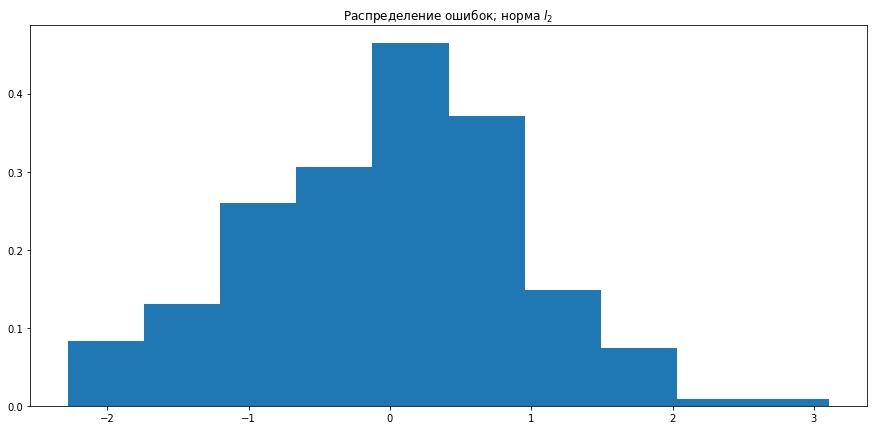

In [49]:
plt.figure(figsize=(15, 7))
x = np.linalg.inv(A.T @ A) @ A.T @ b.T
plt.hist(A @ x - b, bins=10, normed=True)
plt.title('Распределение ошибок; норма $l_{2}$')
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encount

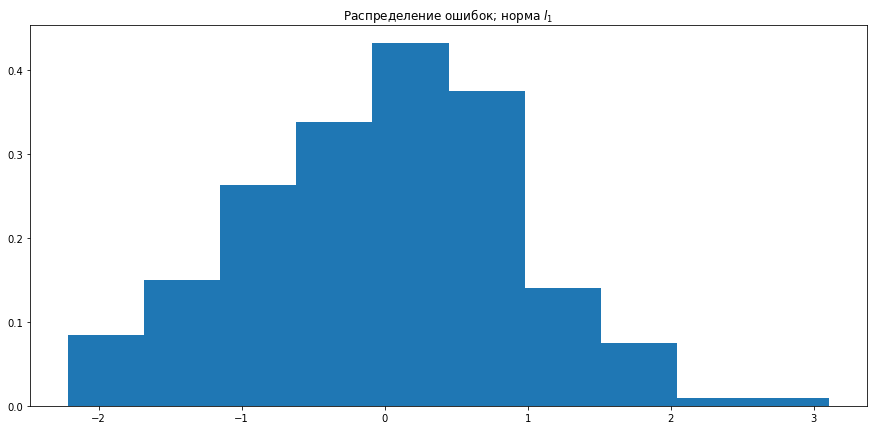

In [51]:
E = np.eye(200)
B = np.vstack((np.hstack((-E, A)), np.hstack((-E, -A))))
b_corr = np.hstack((b, -b))
c = -np.hstack((np.ones(200), np.zeros(3)))
start_point = np.hstack((b, np.zeros(3)))
value, point, iteration = simplex(len(c), B, b_corr, c, start_point=start_point)
x = point[-3:]
x = np.nan_to_num(x)
plt.figure(figsize=(15, 7))
plt.hist(A @ x - b, bins=10, normed=True)
plt.title('Распределение ошибок; норма $l_{1}$')
plt.show()

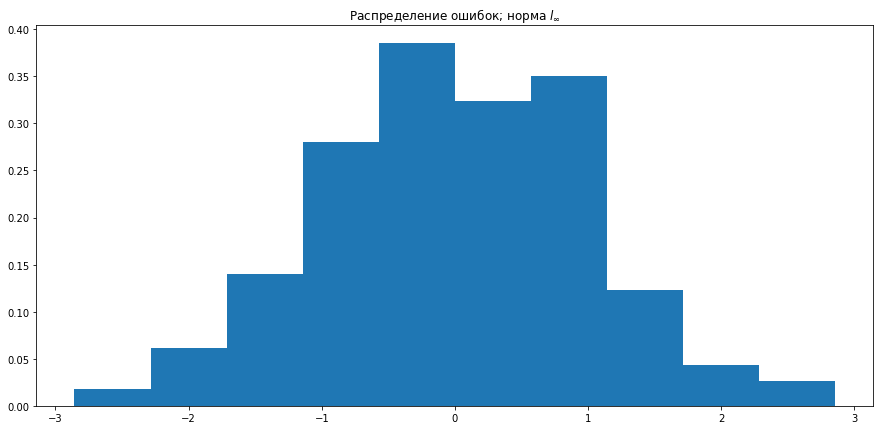

In [50]:
E = np.array([np.ones(200)])
B = np.vstack((np.hstack((-E.T, A)), np.hstack((-E.T, -A))))
b_corr = np.hstack((b, -b))
c = -np.hstack((np.ones(1), np.zeros(3)))
value, point, iteration = simplex(len(c), B, b_corr, c)
x = point[-3:]
plt.figure(figsize=(15, 7))
plt.hist(A @ x - b, bins=10, normed=True)
plt.title('Распределение ошибок; норма $l_{\infty}$')
plt.show()

* $l_{2}$ - нормальное распредеелние (известно из курса математической статистики)
* $l_{1}$ - распределение Лапласа
* $l_{\infty}$ - ?